In [1]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    print(np.max(cleaned))
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    print(needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
    return forces, moments, time     
        
def find_profile(mesh,position):
    import numpy as np
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([position, -4.8, 0.],[position,4.8,0.])
    Udata = x.point_data['U']
    mesh.set_active_scalars('p')
    y = mesh.sample_over_line([position, -4.8, 0.],[position,4.8,0.])
    Pdata = y.point_data['p']
    y = y.points[:,1]
    return Udata,Pdata,y

def VTK_files(folder,debug=False):
    import os
    vtk_exists = os.path.exists(folder + '/VTK')
    if vtk_exists:
        if debug:
            print('VTK Exists for case: {}'.format(folder))
        pass
    else:
        os.system('foamToVTK -case {}'.format(folder))
    for file in os.listdir(folder+'/VTK/'):
        if file[-3:] == 'vtk':
            target = file
        else:
            pass
    return target

def find_peaks(data,n_peaks=1):
    descend = np.argsort(data)[::-1]
    peaks = []
    for i in descend:
        if i != 0 and i != len(data)-1 and data[i] > data[i-1] and data[i] > data[i+1]:
            peaks.append(int(i))
        
        elif len(peaks) >= n_peaks:
            return peaks
            
        else:
            pass
    return peaks
    

In [27]:
## For Impulse Cases

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# import control

# directory = '/media/james/Data/james/completed_cases/coanda_airfoils/impulse_25'
# directory = '/media/james/Data/james/completed_cases/coanda_airfoils/era/'
# directory = '/home/james/Documents/data/unsteady/'
directory = '/home/james/Documents/research/data/theodorsen/'
filename = 'imp_0015dur_200start'
force, moment, time = retrieve_lift(directory+filename)

0.5
False


(1001,)


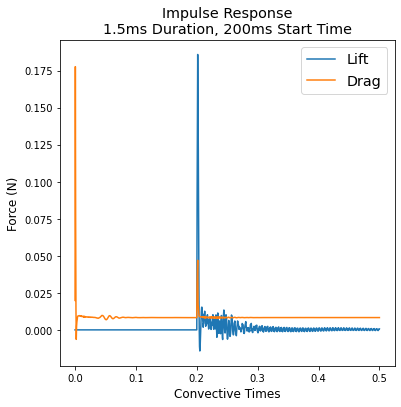

In [31]:
# Direct Data Plotting (Lift and Drag)
lift = force[1:,1]
drag = force[1:,0]

c = 0.3
U = 20
rho = 1.17
b = .61
QS = .5 * rho * U**2 * c * b
tau = c / U
start = 400
dur = 5
input_signal = np.zeros([1001,1])
input_signal[start:start+dur] = 1
CL = lift / QS
print(np.shape(lift))
CD = drag / QS
start = 0
plt.figure(figsize = [6,6])
plt.plot(time[start:],CL[start:])
plt.plot(time[start:],CD[start:])


plt.title("Impulse Response\n1.5ms Duration, 200ms Start Time",fontsize='x-large')
plt.ylabel('Force (N)',fontsize='large')
plt.xlabel('Convective Times',fontsize='large')
plt.legend(['Lift','Drag'],fontsize='x-large')

#plt.savefig('impulse_005dur_100start.png')

['bezier_coanda_init_500.vtk', 'bezier_coanda_init_0.vtk']
500
0
(13321, 2)


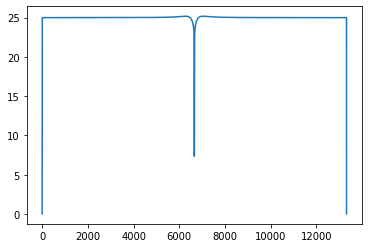

In [23]:
# Profile Extraction 

import numpy as np
import pyvista as pv
import os
from matplotlib import pyplot as plt



directory = '/media/james/Data/james/completed_cases/coanda_airfoils/era/'
directory = '/home/james/Documents/research/cfd/bezier_coanda_init/'
filename = 'std_init_1'
filename = '/'

# data = retrieve_lift(directory)


d = 0.12 *.0254 * 5
target_folder = directory+filename+'/VTK/'

contents = os.listdir(target_folder)
files = [file for file in contents if file[-3:] == 'vtk']
print(files)
numarray = np.zeros(len(files))
targs = []
k = 0

for file in files:
    x = file.split('_')[3].split('.')[0]
    print(x)
    numarray[k] = x
    k+=1

sorter = np.argsort(numarray)

targs = [files[sorter[i]] for i in range(len(files))]
t = np.linspace(0,0.4999,5000)
    
plt.figure()
for i in range(len(targs)):
    target = targs[i]
    
    mesh = pv.read(directory+filename+'/VTK/' + target)

    u, p, y = find_profile(mesh,d)
    if i == 0:
        Ux = u[:,0]
        Uy = u[:,1]
        P = p
        
    else:
        Ux = np.vstack([Ux,u[:,0]])
        Uy = np.vstack([Uy,u[:,1]])
        P = np.vstack([P,p])
#     if i % 500 == 0:
#         print("{}% complete".format(i/50))
        


    

Ux = Ux.T
Uy = Uy.T
P = P.T

print(np.shape(Ux))
plt.plot(Ux[:,1])

In [146]:
# Save extracted profile data

import scipy.io

start = 4000
data = []
plt.figure()
Uyp = np.zeros(np.shape(Uy)[0])
for i in range(0,10):
    
    Uyp += Uy[:,start+i*19]

Uxd = Ux[:,start:start+20]
Uyd = Uy[:,start:start+20]
Pd = P[:,start:start+20]


save_dict = {"Ux": Uxd, "Uy": Uyd, "P": Pd, "y": y}
scipy.io.savemat('./output/shedding_profile.mat', save_dict)

<Figure size 432x288 with 0 Axes>

In [25]:
def BLBClinstab(LHS,RHS,N):
    import numpy as np
    for ni in np.arange(N,4*N+1,N):
        LHS[ni,:] = 0
        RHS[ni,:] = 0
        LHS[ni,ni] = 1
    for ni in np.arange(0,3*N+1,1):
        LHS[ni,:] = 0
        RHS[ni,:] = 0
        LHS[ni,ni] = 1
    LHSbc = LHS
    RHSbc = RHS
    return LHSbc, RHSbc

# function [L,M] = BLOperatorsStabilityNew(Redelta,kx,kz,y,D1,D2,U0,dU0)

# %TODO: Convert Rex to whatever Re we should use
# %Each entry of L should have units of U/L := 1/T
# % For the Blasius version, choose U to be freestream, and L to be delta*


# % A few basic matrices to improve readability
# I   = eye(length(y)); %note that y isn't used for anything else
# Z   = zeros(length(y));

# % Calculate mean shear
# %dU0 = D1*U0;
# U0 = diag(U0);
# dU0 = diag(dU0);

# % Create important block components
# ikU0 = 1i*kx*U0;
# % Laplacian 
# LAP  = -(kx^2)*I - (kz^2)*I + D2;
        
# % Block matrix L representing linearized NS equations
# % Set up the operators based on symmetry
# Re = Redelta;
# % The last column is the pressure gradient, last row is continuity
#         L1 = [-ikU0+LAP/Re, -dU0         , Z           , -1i*kx*I]; %u (ax.)
#         L2 = [Z            , -ikU0+LAP/Re, Z           ,     -D1]; %v (rad.)
#         L3 = [Z            , Z            ,-ikU0+LAP/Re, -1i*kz*I]; %w (az.)
#         L4 = [-1i*kx*I     ,-D1          ,-1i*kz*I     ,        Z]; %contin.

#         L  = [L1; L2; L3; L4];

# % Mass Matrix
# M = [I Z Z Z; Z I Z Z; Z Z I Z; Z Z Z Z]; %changed!!!
# end

def BLOperatorsStabilityNew(Redelta,kx,kz,y,D1,D2,U0,dU0):
    import numpy as np
    I = np.eye(len(y))
    Z = np.zeros(len(y))
    
import numpy as np

np.diag(1)

ValueError: Input must be 1- or 2-d.

0.9036641417336855


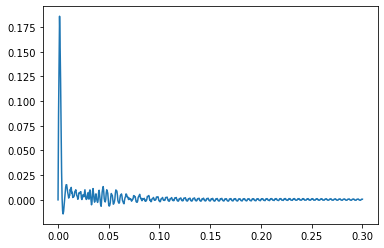

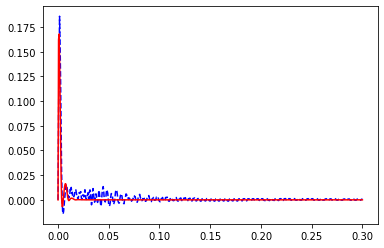

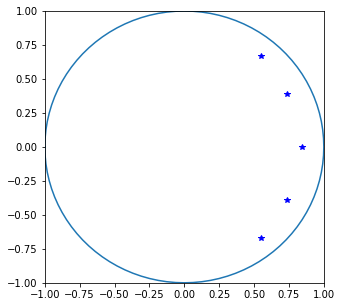

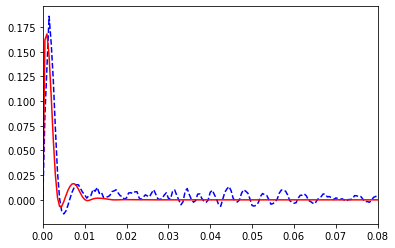

In [67]:
# ERA Implementation

import control.matlab
import random
from scipy import signal
from scipy import io
from scipy import linalg as la
from matplotlib import pyplot as plt

def era(YY,m,n,nin,nout,r):
    from scipy import linalg as la
    import numpy as np
    Dr = np.zeros([nout,nin])
    Y  = np.zeros([nout,nin,len(YY[0,0,:])-1])
    for i in range(nout):
        for j in range(nin):
            Dr[i,j] = YY[i,j,0]
            Y[i,j,:] = YY[i,j,1:]
            
    assert(len(Y[:,0,0])==nout)
    assert(len(Y[0,:,0])==nin)
    assert(len(Y[0,0,:])>=m+n)
    
    H = np.zeros([m,n])
    H2 = np.zeros([m,n])
    
    
    for i in range(m):
        for j in range(n):
            for Q in range(nout):
                for P in range(nin):
                    H[nout*i-nout+Q+1,nin*j-nin+P+1] = Y[Q,P,i+j]
                    H2[nout*i-nout+Q+1,nin*j-nin+P+1] = Y[Q,P,i+j+1]
    [U,S,V] = la.svd(H,full_matrices=False)
    V = V.T
    Sm = np.eye(len(S))*S
    Sigma = Sm[0:r,0:r]
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = np.dot(la.inv(Sigma)**.5,np.dot(Ur.T,np.dot(H2,np.dot(Vr,la.inv((Sigma))**.5))))
    Br = np.dot((Sigma**.5),np.dot(Ur.T,H[:,0:nin]))
    Cr = (np.dot(H[:nout,:],np.dot(Vr, Sigma**(0.5))))
    HSVs = S[0:r]
    return Ar,Br,Cr,Dr,HSVs
    
nInputs = 1
nOutputs = 1
start_index = 400
y = CL[start_index:]
nStates = 5
t = time[start_index:]
t = t - t[0]
dt = t[1]-t[0]
nt = len(t)
dur = 0.0015
plt.figure()
plt.plot(t,y)

NumberTimeShifts = 2*nStates
NumberSnaps = nt-NumberTimeShifts-1
r = nStates
YY = np.zeros([1,1,len(y)])
YY[0,0,:] = y
[Ar,Br,Cr,Dr,HSVs] = era(YY,NumberTimeShifts,NumberSnaps,nInputs, nOutputs, r)

sys2 = control.ss(Ar,Br,Cr*dt/.3,Dr*dt/.3,dt)
y2,t2 = control.matlab.impulse(sys2,t)

plt.figure()
plt.plot(t,y,'b--',t2,y2,'r-')


plt.figure(figsize = [5,5])
xc = np.linspace(-np.pi,np.pi,101)
[vals2,vecs2] = la.eig(sys2.A)
plt.plot(np.real(vals2),np.imag(vals2),'b*')
plt.plot(np.cos(xc),np.sin(xc))
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.figure()
plt.plot(t,y,'b--',t2,y2,'r-')
plt.xlim([0,0.08])

print(np.max(y2)/np.max(y))

save_dict = {"A": Ar, "B": Br, "C": Cr, "D": Dr, "dt": dt}
# print(Ar)
# io.savemat('ss_system.mat',save_dict)


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

directory = '/media/james/Data/james/completed_cases/coanda_airfoils/era/imp_std_2/'
cases = directory
data_dict = {}


forces, moments, time = retrieve_lift(directory)


0.5
False


KeyError: '0.0001'